# Prognozowanie szeregów czasowych

In [14]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Naszą główną biblioteką do szeregów czasowych będzie [sktime](https://www.sktime.net/en/stable/index.html), oferujące interfejs podobny do Scikit-learn. Jest to wrapper na wiele innych bibliotek, między innymi:
- [statsforecast](https://github.com/Nixtla/statsforecast) - wydajna implementacja wielu metod prognozowania, m.in. AutoARIMA i AutoETS
- [pmdarima](https://alkaline-ml.com/pmdarima/) - testy statystyczne dla szeregów czasowych oraz alternatywna implementacja AutoARIMA
- [statsmodels](https://www.statsmodels.org/stable/index.html) - niektóre metody dekompozycji szeregów czasowych i prognozowania

Do obliczania testów statystycznych wykorzystamy [scipy](https://docs.scipy.org/doc/scipy/index.html) oraz [statsmodels](https://www.statsmodels.org/stable/index.html).

## Prognozowanie inflacji w Polsce

Problem przewidywania inflacji (wskaźników cen towarów i usług konsumpcyjnych) jest bardzo powszechny, i wykonuje go zasadniczo każde państwo i większa instytucja finansowa. W praktyce jest to cała grupa interesujących problemów, bo mamy inflację, inflację bazową (po wyłączeniu najbardziej zmiennych czynników, np. cen żywności), 

W Polsce podstawowe dane o inflacji [publikuje Główny Urząd Statystyczny (GUS)](https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/), z częstotliwością miesięczną, kwartalną, półroczną i roczną. Bardziej szczegółowe informacje publikują inne instytucje, bo zależą od przyjętej metodyki, np. inflację bazową [oblicza i publikuje Narodowy Bank Polski (NBP)](https://nbp.pl/statystyka-i-sprawozdawczosc/inflacja-bazowa/).

Prognozowanie inflacji jest wyzwaniem, bo typowo inflacja:
- ma wyraźne cykle, ale wysoce nieregularne
- jest implicite związana z wieloma czynnikami zewnętrznymi (gospodarka światowa, decyzje polityczne etc.)
- nie ma wyraźnej sezonowości
- interesuje nas prognozowanie na wielu poziomach szczególowości, np. miesięczne, kwartalne, roczne

Zajmiemy się danymi z GUS, o częstotliwości miesięcznej. Aby otrzymać inflację rok do roku (RDR), z którą typowo mamy do czynienia, trzeba odjąć 100 od podawanych wartości.

In [15]:
df = pd.read_csv("polish_inflation.csv")
df = df.rename(columns={"Rok": "year", "Miesiąc": "month", "Wartość": "value"})

# create proper date column
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["date"] = df["date"].dt.to_period("M")

# set datetime index
df = df.set_index(df["date"], drop=True)
df = df.sort_index()

# leave only time series values
df = df["value"] - 100
df

date
1982-01     53.2
1982-02    106.4
1982-03    110.7
1982-04    104.1
1982-05    108.4
           ...  
2023-11      6.6
2023-12      6.2
2024-01      3.7
2024-02      2.8
2024-03      2.0
Freq: M, Name: value, Length: 507, dtype: float64

Do rysowania szeregów czasowych najłatwiej użyć funkcji `plot_series` z sktime, która ustawi nam od razu ładnie opisy na osi X.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation'}, ylabel='value'>)

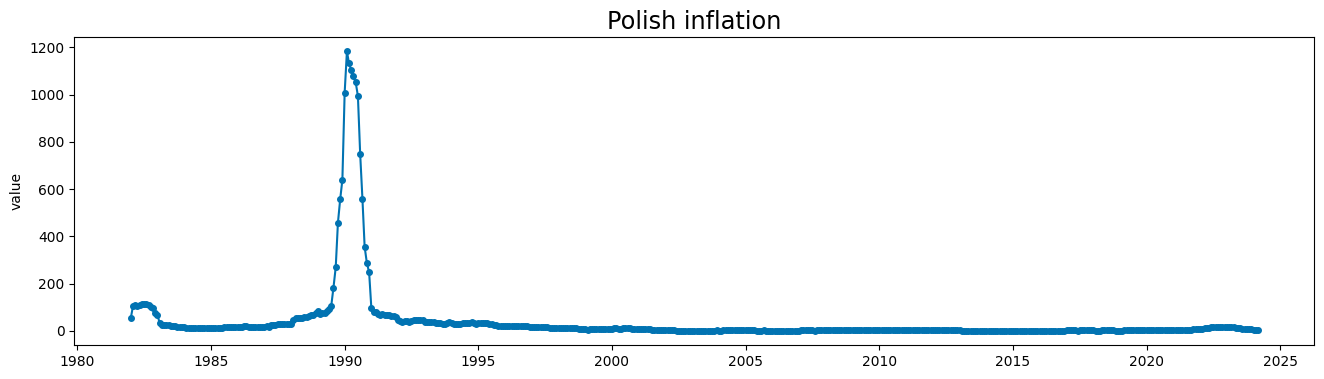

In [16]:
from sktime.utils.plotting import plot_series

plot_series(df, title="Polish inflation")

Tu nie ma błędu - lata 90 były ciekawym okresem, z [hiperinflacją](https://pl.wikipedia.org/wiki/Hiperinflacja#Polska_%E2%80%93_lata_80._XX_wieku), późniejszą [terapią szokową](https://en.wikipedia.org/wiki/Shock_therapy_(economics)) i realizacją [planu Balcerowicza](https://pl.wikipedia.org/wiki/Plan_Balcerowicza). Z perspektywy prognozowania szeregów czasowych jest to ewidentny outlier, ale przy tym bardzo długi. W związku z tym ograniczymy się do późniejszego okresu, od roku 2000.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation, from year 2000'}, ylabel='value'>)

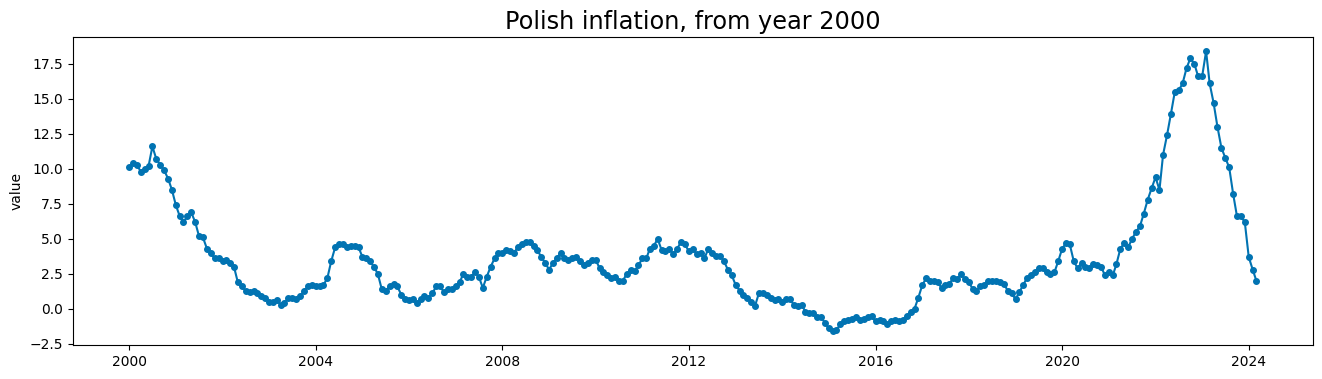

In [17]:
df = df[df.index >= "2000-01"]
plot_series(df, title="Polish inflation, from year 2000")

Już "na oko" widać tutaj ewidentne cykle i trendy. Natomiast są też dobre wieści - inflacja jest dość łagodnie zmiennym agregatem. Pytanie, co z sezonowością?

**Zadanie 1 (0.5 punktu)**

Uzupełnij kod funkcji `plot_stl_decomposition`. Wykorzystaj `STLTransformer` do obliczenia dekompozycji STL ([dokumentacja](https://www.sktime.net/en/v0.29.0/api_reference/auto_generated/sktime.transformations.series.detrend.STLTransformer.html)). Pamiętaj o podaniu odpowiednich opcji, aby uwzględnić podany okres sezonowości, i zwrócić wszystkie trzy komponenty.

Następnie narysuj dekompozycję STL dla danych o inflacji. Skomentuj:
- czy twoim zdaniem widać tutaj roczną sezonowość?
- czy rezydua są białym szumem, czy widać tam jeszcze jakieś informacje do wykorzystania?

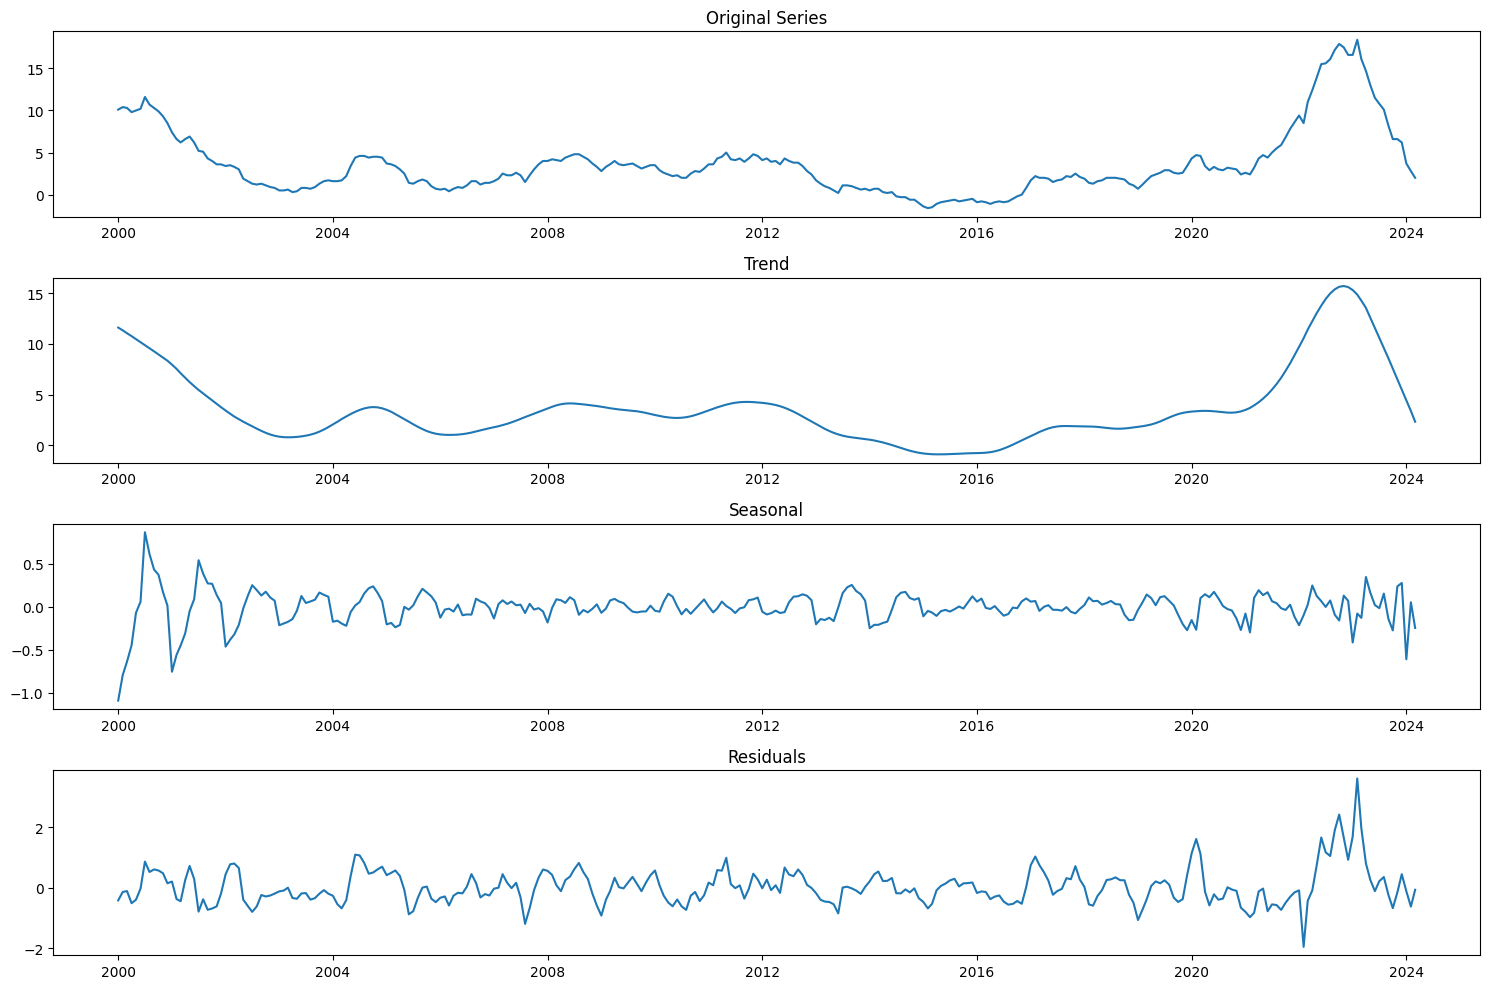

In [18]:
from sktime.transformations.series.detrend import STLTransformer


def plot_stl_decomposition(data: pd.Series, seasonal_period: int = 12) -> None:
    stl = STLTransformer(sp=seasonal_period, return_components=True)
    result = stl.fit_transform(data)
    
    result_df = pd.DataFrame(result, index=data.index)
    
    data = data.to_timestamp()
    result_df.index = result_df.index.to_timestamp()
    
    fig, axs = plt.subplots(4, figsize=(15, 10))
    
    axs[0].plot(data)
    axs[0].set_title('Original Series')
    
    axs[1].plot(result_df['trend'])
    axs[1].set_title('Trend')
    
    axs[2].plot(result_df['seasonal'])
    axs[2].set_title('Seasonal')
    
    axs[3].plot(result_df['resid'])
    axs[3].set_title('Residuals')
    
    plt.tight_layout()
    plt.show()

plot_stl_decomposition(df, seasonal_period=12)

Chyba widoczna jest roczna sezonowość. Widać wzrosty odpowiadające trendom.

Metoda "na oko" z dekompozycją STL jest ważna - to pozwala nabrać intuicji i wiedzy co do danych, i walidować parametry. Ale od tego są procedury automatyczne, z testami statystycznymi, żeby nie trzeba było tak ręcznie.

Sprawdźmy teraz, jak wygląda kwestia sezonowości i stacjonarności. Nie jest to stricte potrzebne dla modeli ETS - one przyjmują dane as-is. Natomiast dla modeli ARIMA jest to już niezbędne, bo wymagają danych stacjonarnych, a wiedza o sezonowości potrafi bardzo przyspieszyć obliczenia (SARIMA jest dużo wolniejsza).

**Zadanie 2 (0.75 punktu)**

1. Sprawdź za pomocą testów statystycznych dla sezonowości, czy w danych występuje sezonowość kwartalna, półroczna lub roczna. Przyda się funkcja `nsdiffs` z biblioteki pmdarima. Jeżeli wykryto sezonowość, to usuń ją z pomocą klasy `Differencer` z sktime ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html)) oraz narysuj wartości na wykresie.

2. Sprawdź za pomocą testów statystycznych dla stacjonarności, jaki rząd różnicowania stacjonaryzuje szereg. Przyda się funkcja `ndiffs` z biblioteki pmdarima. Jeżeli jest większy niż zero, to usuń stacjonarość za pomocą klasy `Differencer` i narysuj wykres wartości po różnicowaniu.

3. Skomentuj, z jakiego wariantu modeli ARIMA byś skorzystał i dlaczego, na podstawie obecnej wiedzy: ARMA, ARIMA czy SARIMA.

Skorzystaj z domyślnych wartości `D_max` oraz `d_max`.

**Uwaga:** stwórz tutaj nowe zmienne dla wartości po różnicowaniu, nie nadpisuj `df`. Jeszcze nam się przyda.

Wykryto sezonowość na poziomie: 0 dla okresu 12 miesięcy
Wykryto sezonowość na poziomie: 0 dla okresu 6 miesięcy
Wykryto sezonowość na poziomie: 0 dla okresu 4 miesięcy
Wykryto stacjonarność na poziomie: 1


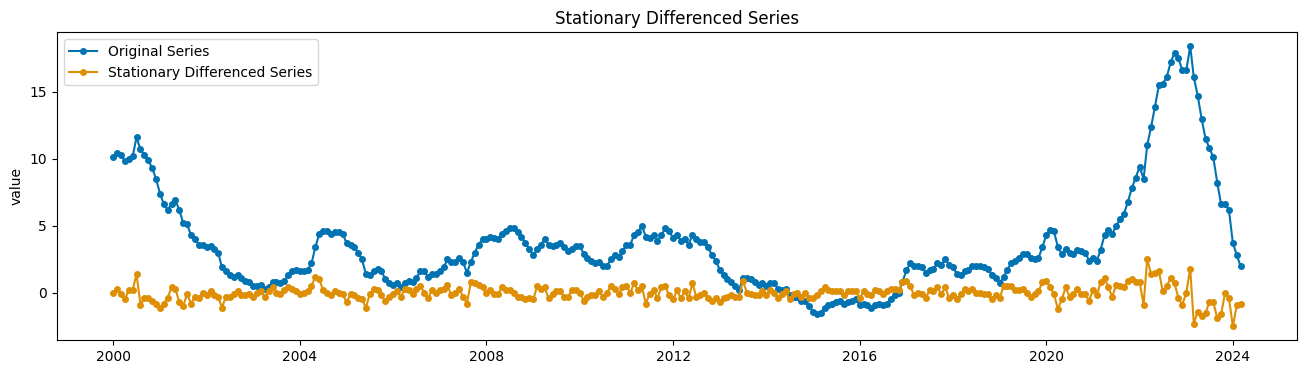

Na podstawie analizy danych, najlepiej skorzystać z modelu ARIMA.


In [19]:
from pmdarima.arima.utils import ndiffs, nsdiffs
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series

def check_seasonality(df, periods):
    for m in periods:
        seasonal_diffs = nsdiffs(df, m=m)
        print(f'Wykryto sezonowość na poziomie: {seasonal_diffs} dla okresu {m} miesięcy')
        
        if seasonal_diffs > 0:
            differencer_seasonal = Differencer(lags=seasonal_diffs * m)
            df_seasonal_diff = differencer_seasonal.fit_transform(df)
            plot_series(df, df_seasonal_diff, labels=["Original Series", f"Seasonally Differenced Series (m={m})"])
            plt.title(f'Seasonally Differenced Series (m={m})')
            plt.show()

check_seasonality(df, periods=[12, 6, 4])

d = ndiffs(df)
print(f'Wykryto stacjonarność na poziomie: {d}')

if d > 0:
    differencer_stationary = Differencer(lags=d)
    df_stationary_diff = differencer_stationary.fit_transform(df)
    plot_series(df, df_stationary_diff, labels=["Original Series", "Stationary Differenced Series"])
    plt.title('Stationary Differenced Series')
    plt.show()

if any(nsdiffs(df, m=m) > 0 for m in [12, 6, 4]):
    model_type = "SARIMA"
elif d > 0:
    model_type = "ARIMA"
else:
    model_type = "ARMA"

print(f'Na podstawie analizy danych, najlepiej skorzystać z modelu {model_type}.')

Na podstawie analizy danych, najlepiej skorzystać z modelu ARIMA.

Jesteśmy już zasadniczo gotowi do treningu modeli. Do testowania wykorzystamy 20% najnowszych danych, ze strategią expanding window, i krokiem 1 (bo mamy odczyty inflacji co miesiąc). Naszymi metrykami będą MAE, SMAPE oraz MASE.

Wykonamy też analizę rezyduów. Błędy powinny mieć rozkład normalny (model bez biasu) oraz nie mieć autokorelacji (model wykorzystujący całą wiedzę). Na potrzeby wszystkich testów statystycznych zakładamy poziom istotności $\alpha = 0.05$.

Wykorzystamy test normalności Anderson-Darling, bo jest nieco "luźniejszy" niż test Shapiro-Wilk, co jest przydatne w praktyce - błędy rzadko kiedy są bardzo blisko rozkładu normalnego. Hipotezą zerową jest, że wartości pochodzą z danego rozkładu (domyślnie normalnego), a alternatywną, że z jakiegoś innego.

Dla testowania autokorelacji błędów użyjemy testu Ljung-Box, który testuje autokorelację błędów dla różnych lagów. Dla każdego laga ma osobny test, w którym hipotezą zerową jest brak autokorelacji, a hipotezą alternatywą autokorelacja błędów dla danego opóźnienia.

**Zadanie 3 (1.5 punktu)**

Uzupełnij kod funkcji `evaluate_model`:
1. Stwórz `ExpandingWindowSplitter` ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.split.ExpandingWindowSplitter.html)), który zacznie swoje działanie od 80% danych. Wielkość okna wyznacza argument `horizon`.
2. Stwórz listę metryk składającą się z MAE, SMAPE oraz MASE, z biblioteki sktime.
3. Przeprowadź ewaluację modelu za pomocą funkcji `evaluate` ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html)). Przekaż `return_data=True`, żeby zwrócić też obliczone predykcje. Zwraca ona DataFrame z wynikami.
4. Oblicz średnie wartości metryk z wynikowego DataFrame'a. Wypisz je zaokrąglone do 2 miejsc po przecinku.
5. Uwzględniając argument `analyze_residuals`, przeprowadź analizę błędów:
   - oblicz rezydua jako $y - \hat{y}$
   - narysuj histogram rezyduów
   - wykonaj test Anderson-Darling z biblioteki `scipy` i wypisz, czy rozkład jest normalny, czy nie
   - przetestuj test Ljung-Box z biblioteki `statsmodels` i wypisz wyniki testu

Następnie przetestuj tę funkcję na dwóch baseline'ach: średniej oraz ostatniej znanej wartości. Skorzystaj z klasy `NaiveForecaster` ([dokumentacja](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)), i horyzontu czasowego 3 miesięcy. Narysuj też wykresy predykcji.

MAE: 1.85, SMAPE: 0.27, MASE: 5.45


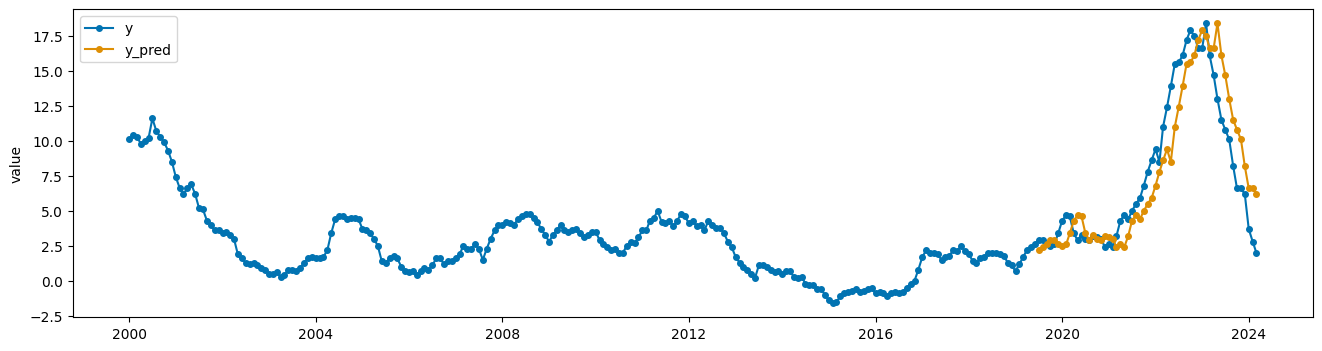

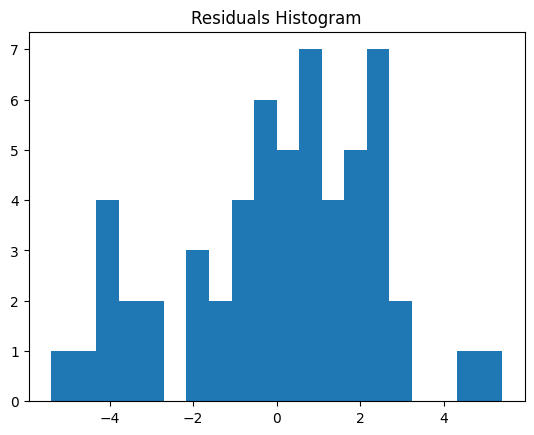

Anderson-Darling test statistic: 0.62, critical values: [0.542 0.617 0.741 0.864 1.028]
Residuals are normally distributed
Ljung-Box test p-value: 8.598560895011705e-30
Autocorrelation detected in residuals
MAE: 1.85, SMAPE: 0.27, MASE: 5.45


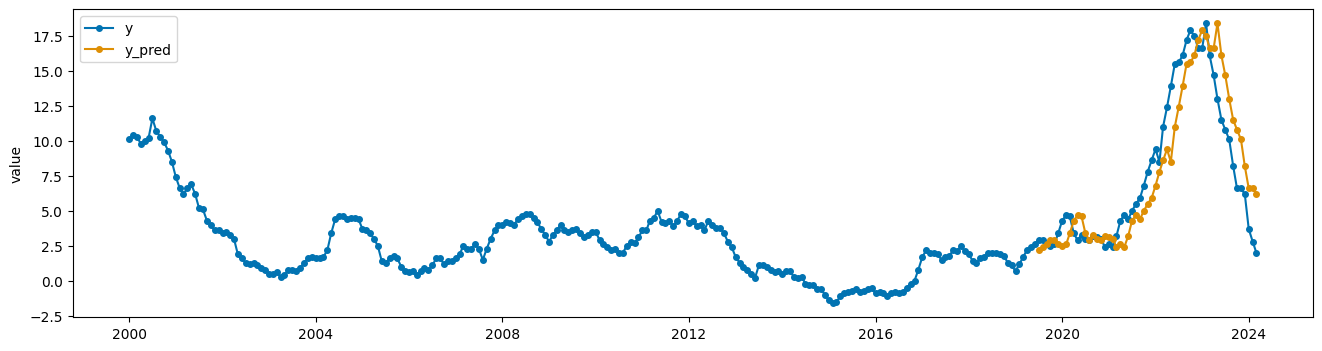

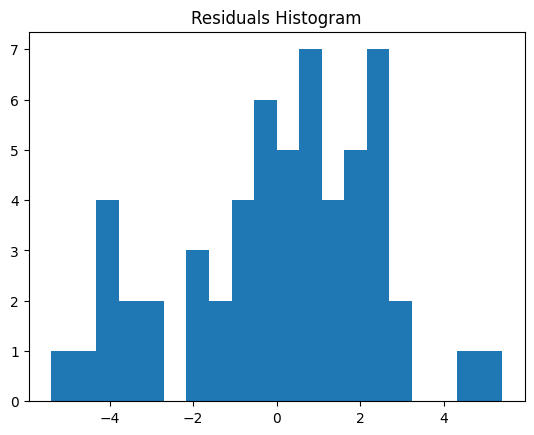

Anderson-Darling test statistic: 0.62, critical values: [0.542 0.617 0.741 0.864 1.028]
Residuals are normally distributed
Ljung-Box test p-value: 8.598560895011705e-30
Autocorrelation detected in residuals


In [20]:
from scipy.stats import anderson
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteScaledError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from statsmodels.stats.diagnostic import acorr_ljungbox
from sktime.forecasting.naive import NaiveForecaster



def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    cv = ExpandingWindowSplitter(initial_window=int(0.8 * len(data)), step_length=1, fh=horizon)
    metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(symmetric=True), MeanAbsoluteScaledError(sp=1)]
    results = evaluate(model, cv, data, return_data=True, scoring=metrics)

    # extract and print metrics
    mae = results['test_MeanAbsoluteError'].mean()
    smape = results['test_MeanAbsolutePercentageError'].mean()
    mase = results['test_MeanAbsoluteScaledError'].mean()
    print(f'MAE: {mae:.2f}, SMAPE: {smape:.2f}, MASE: {mase:.2f}')

    y_pred = pd.concat(results["y_pred"].values)

    if plot_forecasts:
        y_true = data[y_pred.index]
        plot_series(data, y_pred, labels=["y", "y_pred"])
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        y_true = data[y_pred.index]
        residuals = y_true - y_pred
        
        plt.hist(residuals, bins=20)
        plt.title('Residuals Histogram')
        plt.show()
        
        ad_test = anderson(residuals)
        print(f'Anderson-Darling test statistic: {ad_test.statistic:.2f}, critical values: {ad_test.critical_values}')
        print('Residuals are normally distributed' if ad_test.statistic < ad_test.critical_values[2] else 'Residuals are not normally distributed')
        
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        print('Ljung-Box test p-value:', lb_test['lb_pvalue'].values[0])
        print('No autocorrelation in residuals' if lb_test['lb_pvalue'].values[0] > 0.05 else 'Autocorrelation detected in residuals')


naive_mean = NaiveForecaster(strategy="mean", window_length=1)
evaluate_model(naive_mean, df, horizon=3, plot_forecasts=True, analyze_residuals=True)

naive_last = NaiveForecaster(strategy="last", window_length=1)
evaluate_model(naive_last, df, horizon=3, plot_forecasts=True, analyze_residuals=True)


Mamy już pierwsze baseline'y, wyniki z nich wyglądają dość solidnie. Zobaczmy, czy ETS albo ARIMA będą w stanie je przebić.

**Zadanie 4 (0.75 punktu)**

1. Dokonaj predykcji algorytmem AutoETS (klasa `StatsForecastAutoETS`), w wariancie damped trend. Narysuj też predykcje i dokonaj analizy błędów.
2. Analogicznie, dokonaj predykcji algorytmem AutoARIMA (klasa `StatsForecastAutoARIMA`). Jeżeli nie wykryto wcześniej sezonowości, to przekaż odpowiednią opcję, żeby ją wyłączyć - SARIMA jest dużo wolniejsza niż ARIMA.
3. Skomentuj wyniki:
   - czy udało się przebić baseline'y?
   - który z modeli jest lepszy, i o czym może to świadczyć?
   - czy modele są, przynajmniej w przybliżeniu, poprawne, tzn. mają normalne i nieskorelowane błędy?
   - czy wyniki najlepszego modelu są subiektywnie zadowalające?

Wykonaj tutaj predykcje 3-miesięczne, tak jak wcześniej.

MAE: 1.42, SMAPE: 0.23, MASE: 4.26


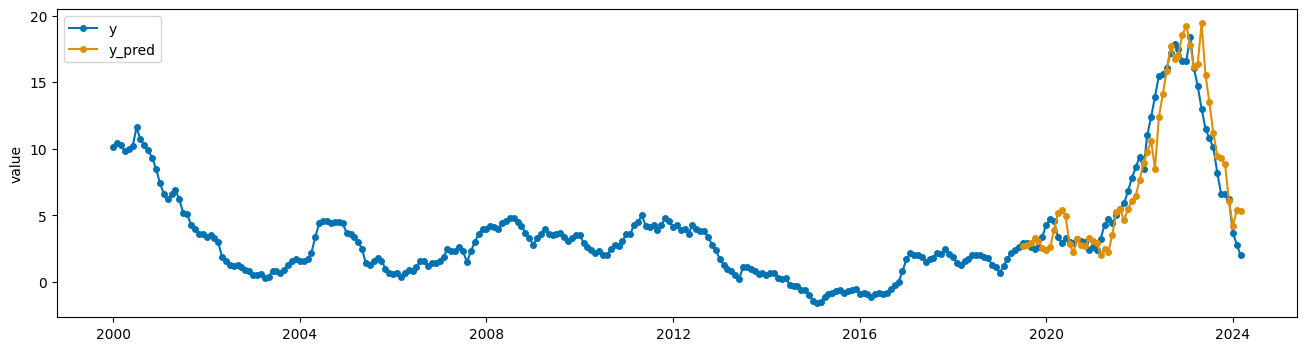

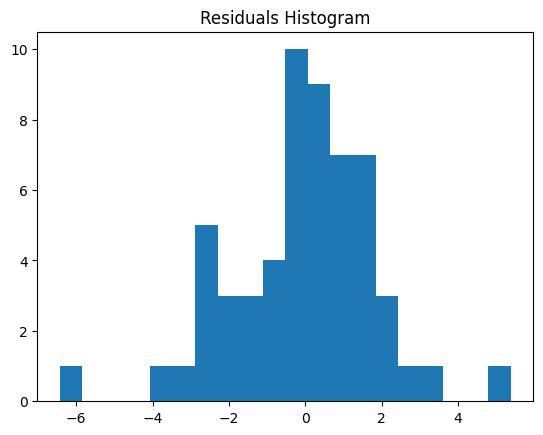

Anderson-Darling test statistic: 0.54, critical values: [0.542 0.617 0.741 0.864 1.028]
Residuals are normally distributed
Ljung-Box test p-value: 2.357906350698292e-10
Autocorrelation detected in residuals
MAE: 1.50, SMAPE: 0.23, MASE: 4.45


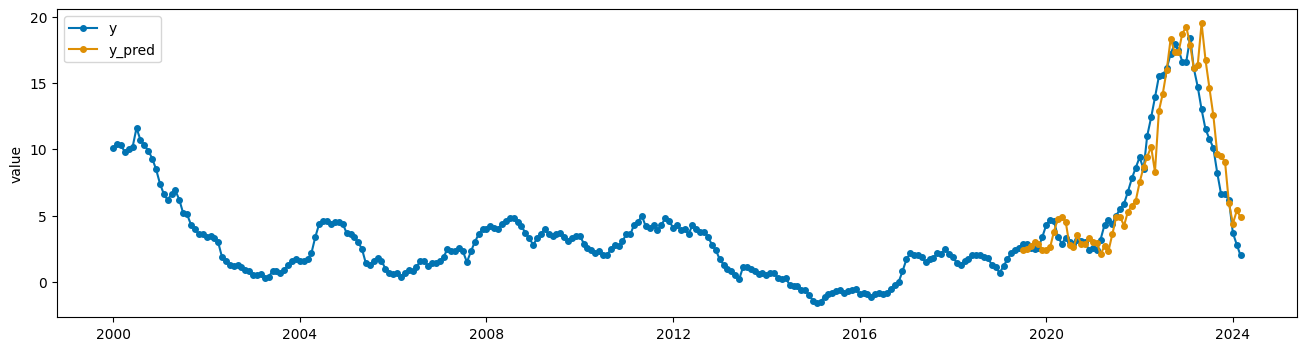

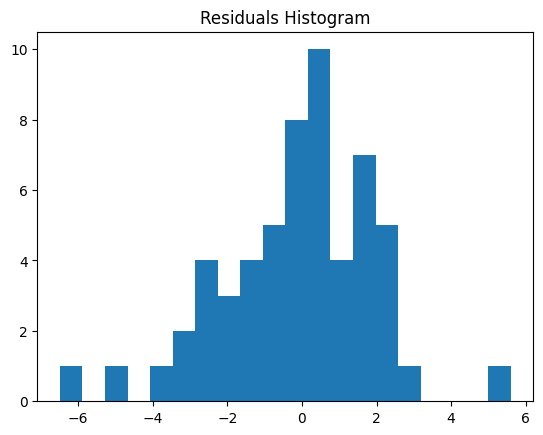

Anderson-Darling test statistic: 0.70, critical values: [0.542 0.617 0.741 0.864 1.028]
Residuals are normally distributed
Ljung-Box test p-value: 1.6047789322789168e-14
Autocorrelation detected in residuals


In [21]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA


auto_ets = AutoETS(auto=True, damped_trend=True)
evaluate_model(auto_ets, df, horizon=3, plot_forecasts=True, analyze_residuals=True)


auto_arima = AutoARIMA(sp=1, seasonal=False)
evaluate_model(auto_arima, df, horizon=3, plot_forecasts=True, analyze_residuals=True)

// skomentuj tutaj

Prognozowanie 3-miesięczne było jednak dość krótkim horyzontem czasowym. Pytanie, co z dalszymi - półrocznym i rocznym. Są one często równie, albo nawet bardziej interesujące, np. w kontekście planowania budżetowego.

**Zadanie 5 (0.75 punktu)**

Dokonaj prognoz dla 6-miesięcznego oraz rocznego horyzontu:
- 2 baseline'ami
- metodami ETS oraz ARIMA
- dla najlepszego modelu narysuj prognozy oraz dokonaj analizy błędów

Skomentuj:
- czy widać jakieś zmiany między modelami w stosunku do przypadku 3-miesięcznego?
- jak zmienia się jakość prognoz przy większych horyzontach czasowych?
- czy te modele dla dłuższych horyzontów są twoim zdaniem użyteczne?


Horizon: 6 months
Naive (mean):
MAE: 4.67, SMAPE: 0.59, MASE: 13.79


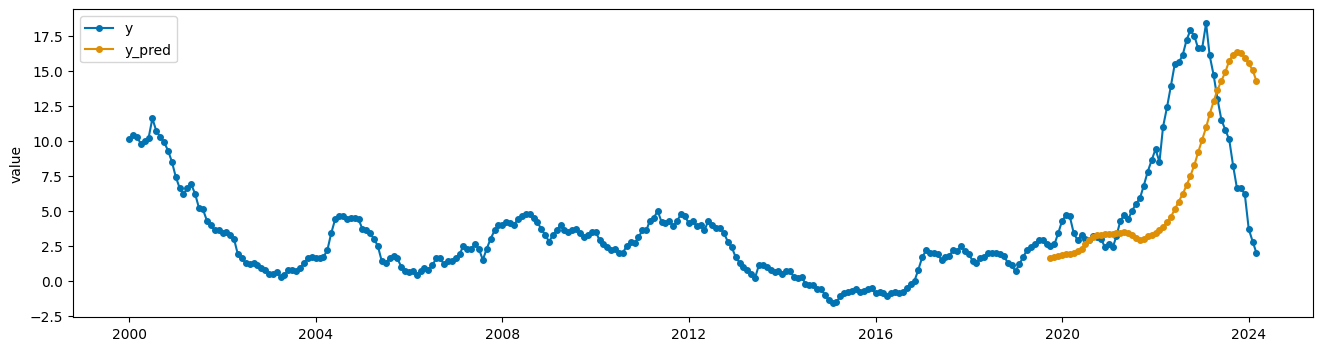

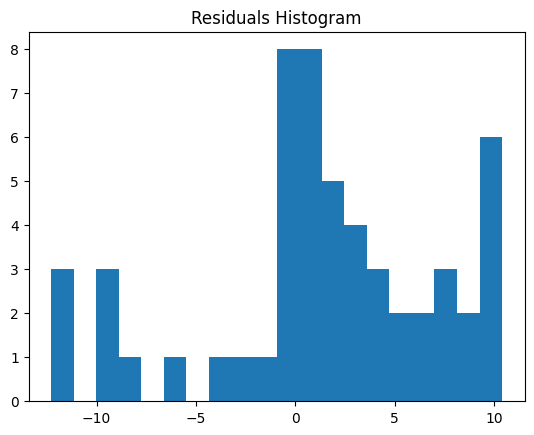

Anderson-Darling test statistic: 1.19, critical values: [0.541 0.616 0.739 0.862 1.025]
Residuals are not normally distributed
Ljung-Box test p-value: 1.130678696507584e-33
Autocorrelation detected in residuals
Naive (last):
MAE: 3.30, SMAPE: 0.42, MASE: 9.80


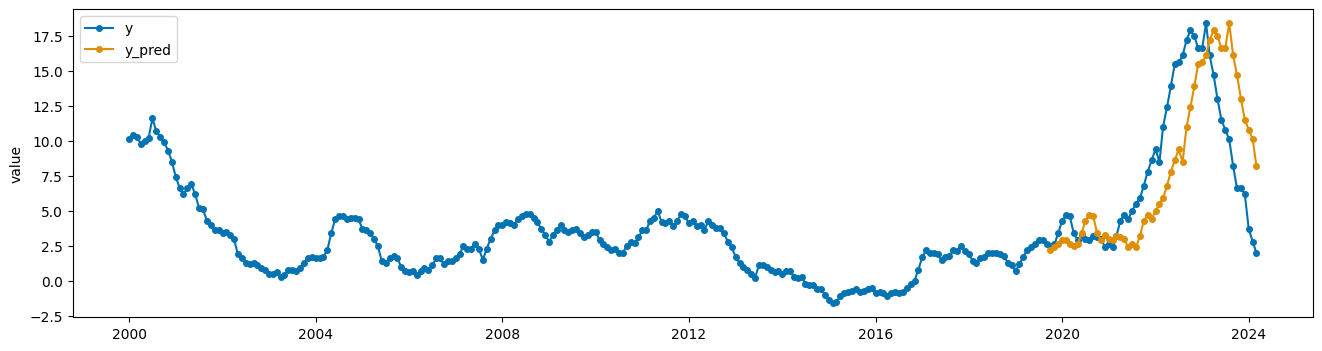

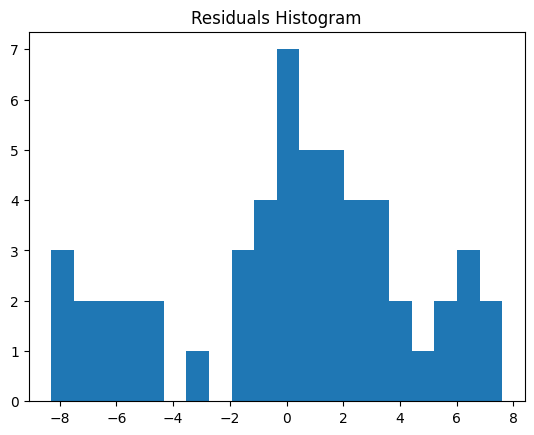

Anderson-Darling test statistic: 0.90, critical values: [0.541 0.616 0.739 0.862 1.025]
Residuals are not normally distributed
Ljung-Box test p-value: 4.158510148600148e-38
Autocorrelation detected in residuals

Horizon: 12 months
Naive (mean):
MAE: 5.69, SMAPE: 0.71, MASE: 17.51


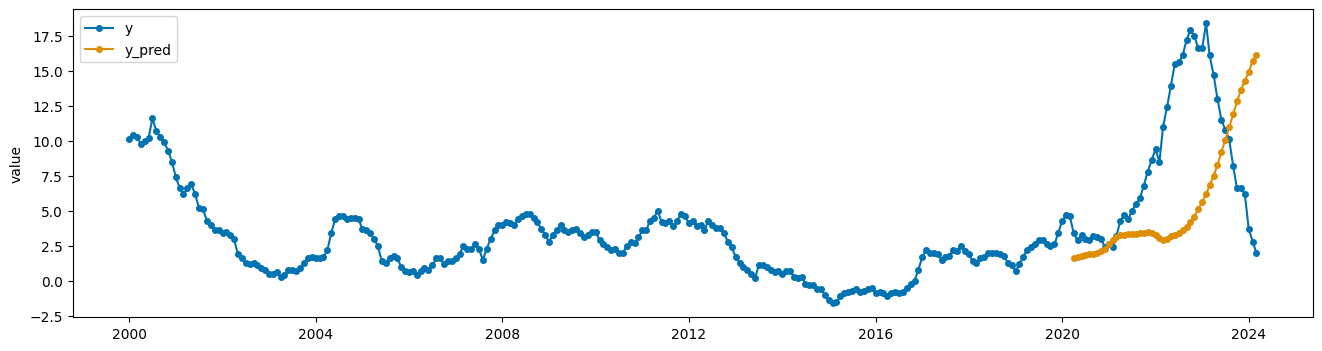

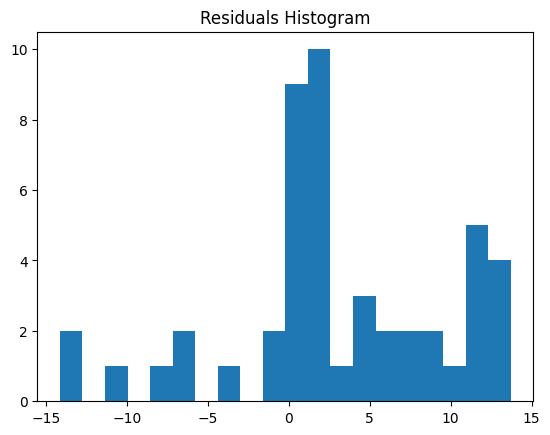

Anderson-Darling test statistic: 1.11, critical values: [0.537 0.612 0.734 0.856 1.018]
Residuals are not normally distributed
Ljung-Box test p-value: 3.0667693925906483e-26
Autocorrelation detected in residuals
Naive (last):
MAE: 5.65, SMAPE: 0.65, MASE: 17.26


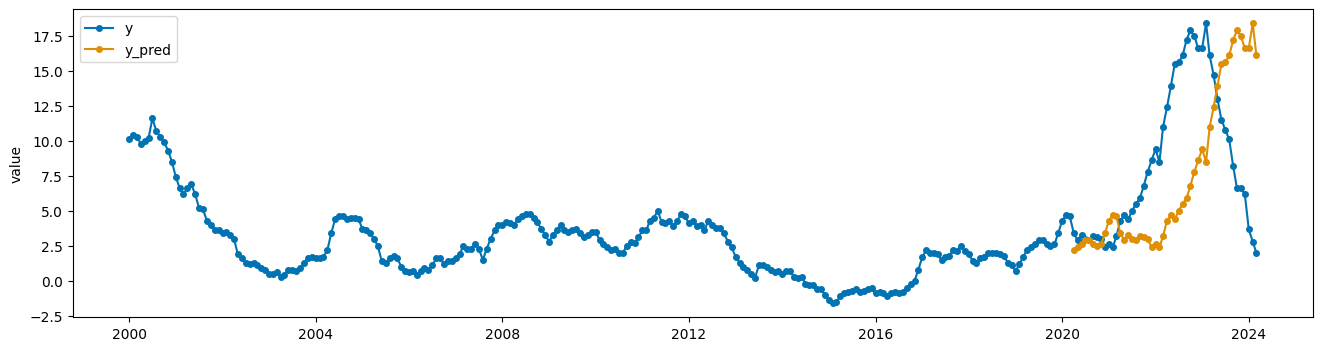

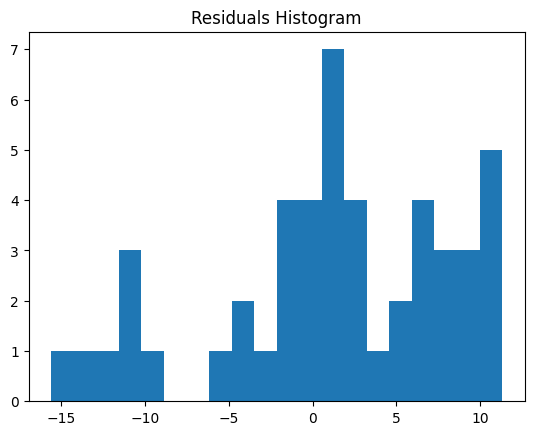

Anderson-Darling test statistic: 0.86, critical values: [0.537 0.612 0.734 0.856 1.018]
Residuals are not normally distributed
Ljung-Box test p-value: 8.114863427518798e-29
Autocorrelation detected in residuals

Horizon: 6 months
AutoETS:
MAE: 2.81, SMAPE: 0.38, MASE: 8.39


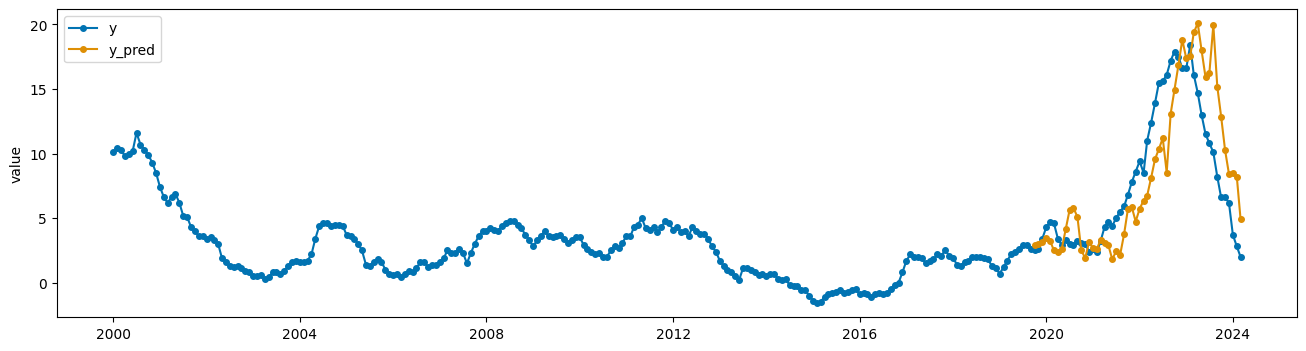

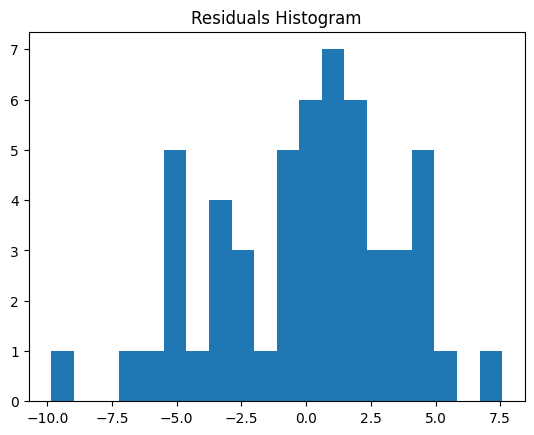

Anderson-Darling test statistic: 0.51, critical values: [0.541 0.616 0.739 0.862 1.025]
Residuals are normally distributed
Ljung-Box test p-value: 3.308226954870944e-30
Autocorrelation detected in residuals
AutoARIMA:
MAE: 2.98, SMAPE: 0.39, MASE: 8.87


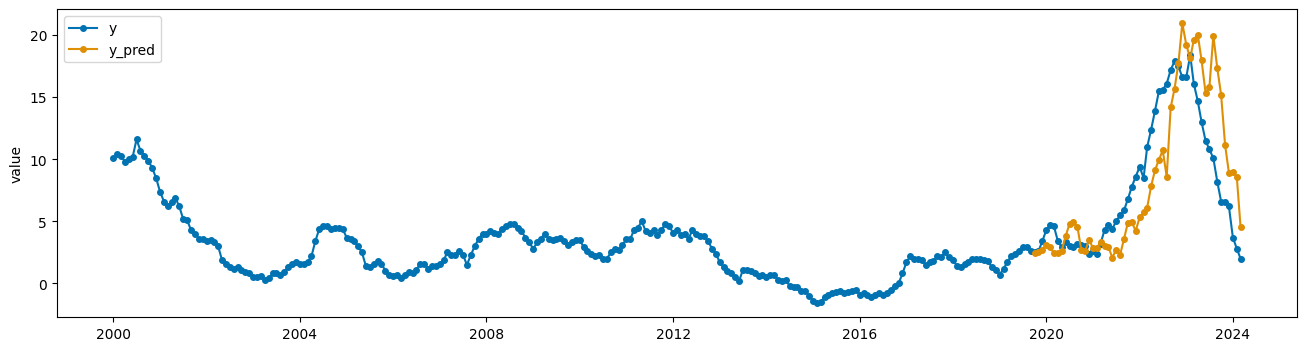

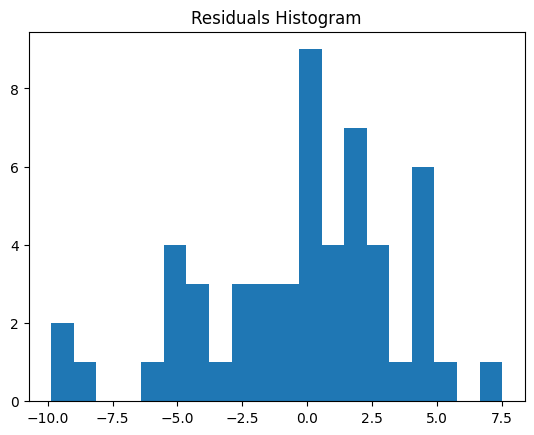

Anderson-Darling test statistic: 0.56, critical values: [0.541 0.616 0.739 0.862 1.025]
Residuals are normally distributed
Ljung-Box test p-value: 3.911860921599918e-32
Autocorrelation detected in residuals

Horizon: 12 months
AutoETS:
MAE: 5.79, SMAPE: 0.67, MASE: 17.64


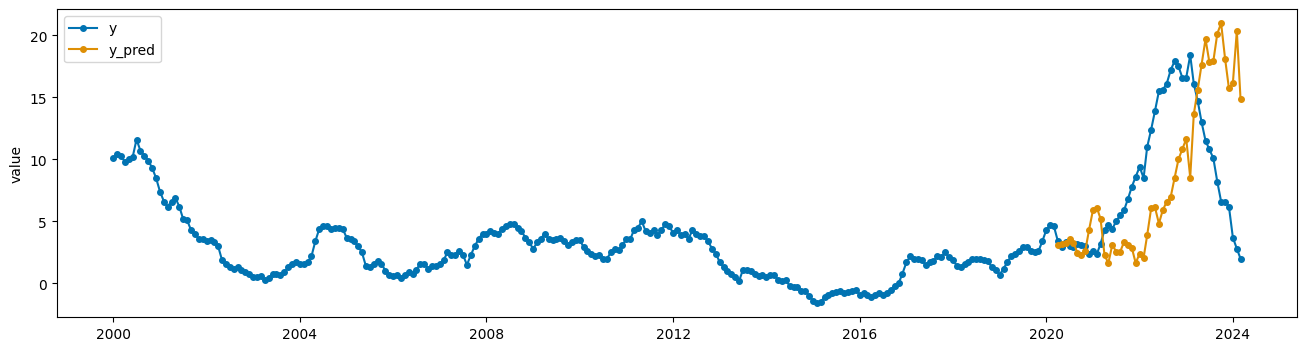

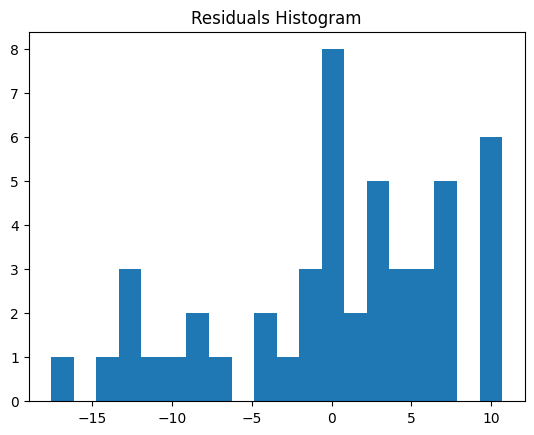

Anderson-Darling test statistic: 0.87, critical values: [0.537 0.612 0.734 0.856 1.018]
Residuals are not normally distributed
Ljung-Box test p-value: 2.437999353194421e-28
Autocorrelation detected in residuals
AutoARIMA:
MAE: 6.06, SMAPE: 0.66, MASE: 18.39


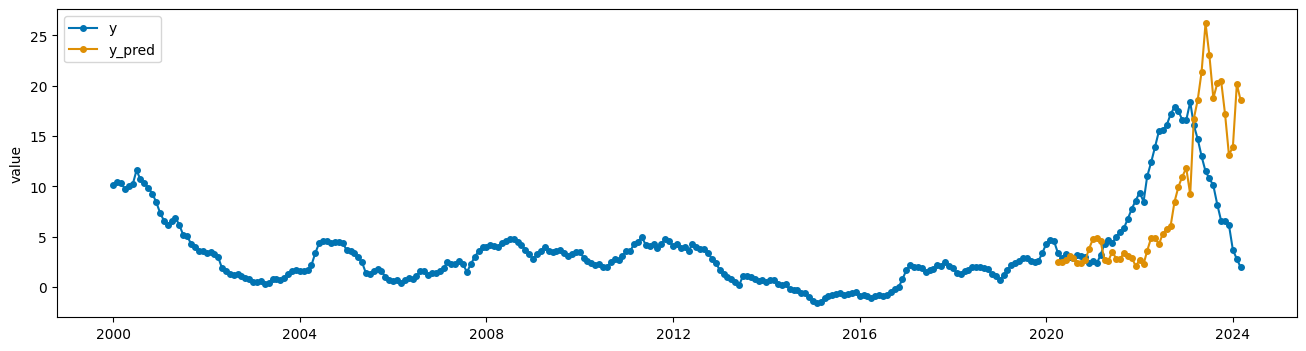

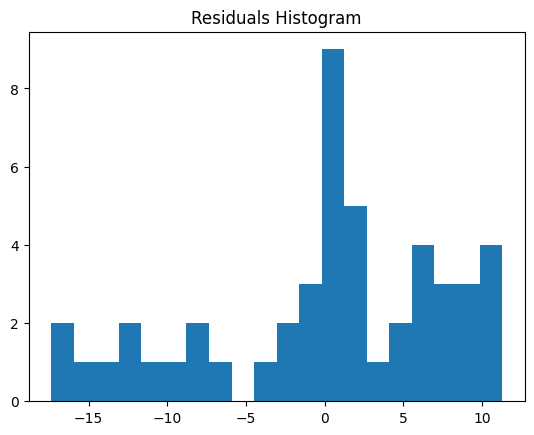

Anderson-Darling test statistic: 1.03, critical values: [0.537 0.612 0.734 0.856 1.018]
Residuals are not normally distributed
Ljung-Box test p-value: 3.2231586066569508e-27
Autocorrelation detected in residuals


In [25]:
from sktime.forecasting.naive import NaiveForecaster

naive_mean = NaiveForecaster(strategy="mean", window_length=12)
naive_last = NaiveForecaster(strategy="last", window_length=12)


data = pd.Series(df)

horizons = [6, 12]

for horizon in horizons:
    print(f"\nHorizon: {horizon} months")
    print("Naive (mean):")
    evaluate_model(naive_mean, data, horizon=horizon, plot_forecasts=True, analyze_residuals=True)
    
    print("Naive (last):")
    evaluate_model(naive_last, data, horizon=horizon, plot_forecasts=True, analyze_residuals=True)


auto_ets = AutoETS(auto=True, sp=12)
auto_arima = AutoARIMA(suppress_warnings=True, stepwise=True)

for horizon in horizons:
    print(f"\nHorizon: {horizon} months")
    print("AutoETS:")
    evaluate_model(auto_ets, data, horizon=horizon, plot_forecasts=True, analyze_residuals=True)
    
    print("AutoARIMA:")
    evaluate_model(auto_arima, data, horizon=horizon, plot_forecasts=True, analyze_residuals=True)



// skomentuj tutaj

## Prognozowanie ruchu sieciowego

Teraz zajmiemy się problemem o zupełnie innej charakterystyce - prognozowaniem ruchu sieciowego. Jest to kluczowe zadanie pod kątem skalowania serwerów, coraz częściej realizowane z pomocą właśnie prognozowania szeregów czasowych. Tzw. predictive scaling implementują między innymi [AWS](https://docs.aws.amazon.com/autoscaling/ec2/userguide/ec2-auto-scaling-predictive-scaling.html), [GCP](https://cloud.google.com/compute/docs/autoscaler/predictive-autoscaling) i [Azure](https://learn.microsoft.com/en-us/azure/azure-monitor/autoscale/autoscale-predictive), istnieją także rozwiązania dla Kubernetesa, [open source](https://predictive-horizontal-pod-autoscaler.readthedocs.io/en/latest/), oraz [komercyjne](https://keda.sh/blog/2022-02-09-predictkube-scaler/). Prognozowanie szeregów czasowych pozwala proaktywnie dokładać kolejne maszyny wirtualne, aby przygotować się na zwiększony ruch i zapewnić niskie opóźnienia, oraz redukuje koszty, automatycznie wyłączając je przy przewidywanym małym ruchu.

Wikipedia i Google hostowały [konkurs na platformie Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting), w którym zadaniem było prognozowanie ruchu na poszczególnych stronach. Jest on dość kolosalny, dlatego na jego podstawie przygotowano uproszczony, w którym mamy zapisaną sumaryczną liczbę requestów do Wikipedii, liczoną w milionach.

Charakterystyki takiego zadania to typowo:
- krótkoterminowe prognozy
- duża częstotliwość danych
- dynamicznie zmienne i zaszumione dane (np. przez aktywność botów)
- bardzo częsty retrening modeli
- duża potrzeba automatyzacji, brak ręcznej analizy modeli

,value
2015-07-01,148.672476
2015-07-02,149.593840
2015-07-03,141.164198
2015-07-04,145.612937
2015-07-05,151.495372
...,...
2017-09-06,172.354146
2017-09-07,180.731284
2017-09-08,136.754670
2017-09-09,132.359512


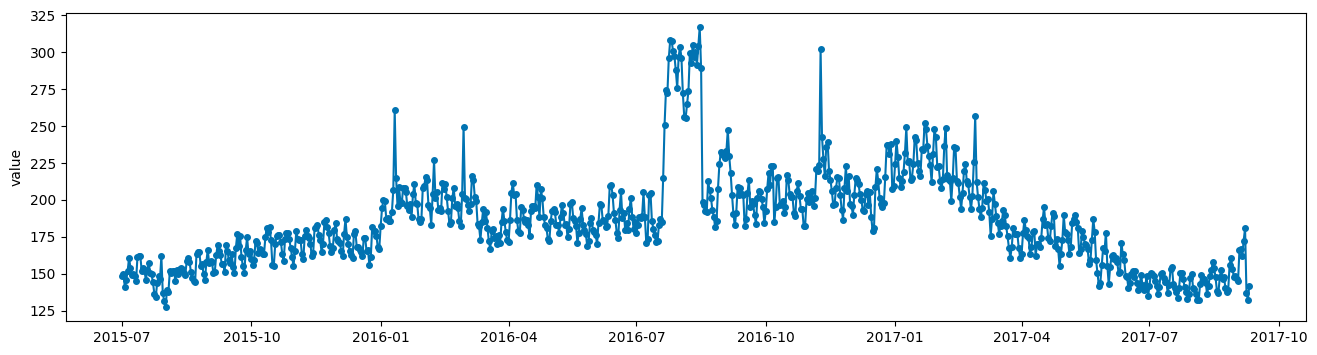

In [ ]:
df = pd.read_parquet("wikipedia_traffic.parquet")
df = df.set_index("date").to_period(freq="d")
plot_series(df)
df

**Zadanie 6 (1 punkt)**

Zakładając horyzont 1 dnia, wytrenuj modele i dokonaj ich ewaluacji (analogicznie do poprzedniego zbioru danych):
- 2 modele baseline'owe
- model ETS (z damped trend)
- model ARIMA (bez sezonowości)
- model SARIMA

Skomentuj:
- czy z tych wyników można wnioskować, że mamy tu sezonowość?
- czy udało się przebić baseline?

Naive (mean):
MAE: 3.87, SMAPE: 0.54, MASE: 11.21


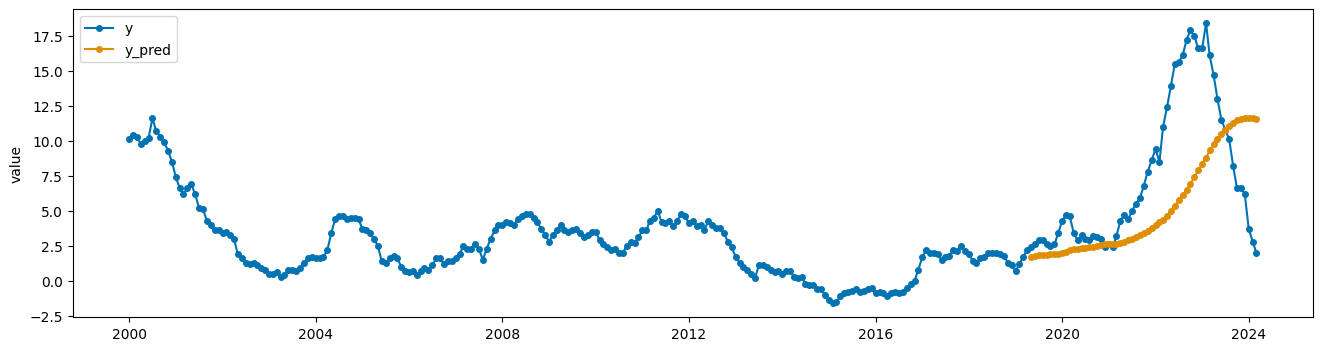

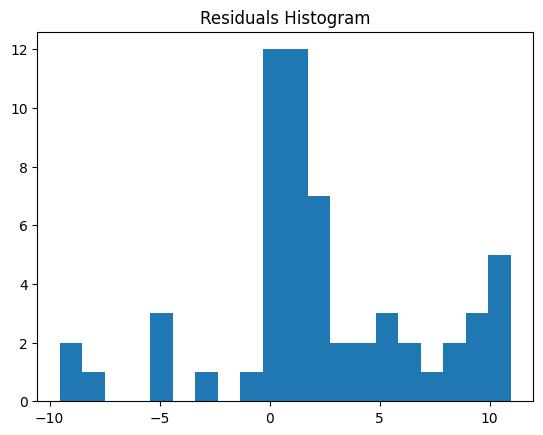

Anderson-Darling test statistic: 1.70, critical values: [0.543 0.619 0.742 0.866 1.03 ]
Residuals are not normally distributed
Ljung-Box test p-value: 2.6292292046786337e-35
Autocorrelation detected in residuals
Naive (last):
MAE: 0.76, SMAPE: 0.12, MASE: 2.23


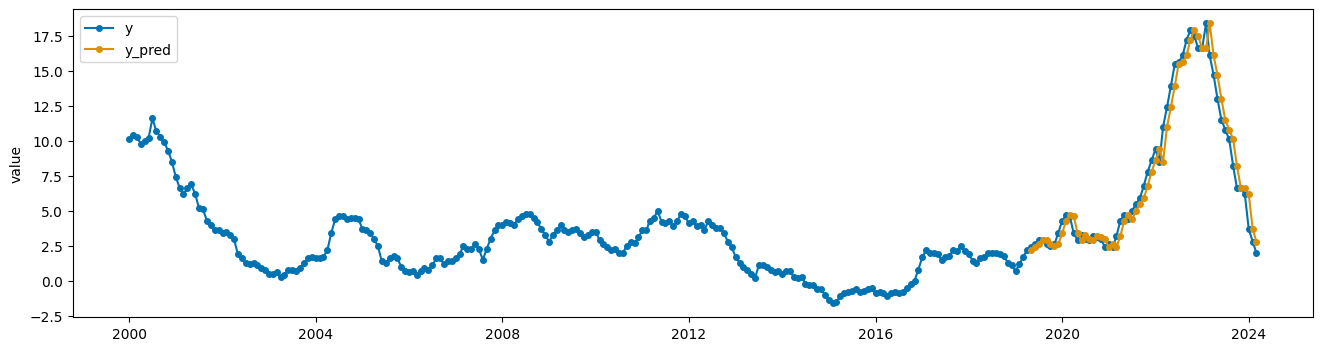

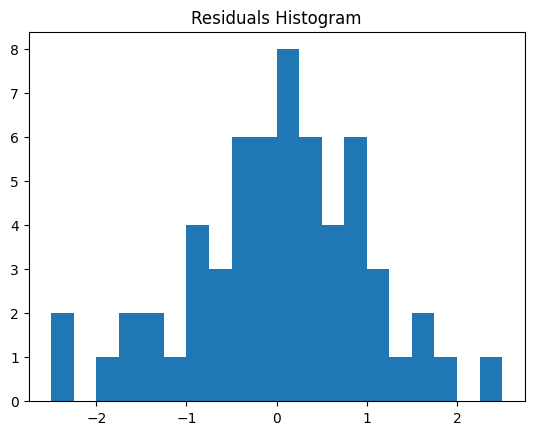

Anderson-Darling test statistic: 0.34, critical values: [0.543 0.619 0.742 0.866 1.03 ]
Residuals are normally distributed
Ljung-Box test p-value: 5.84115833322607e-09
Autocorrelation detected in residuals
AutoETS:
MAE: 0.61, SMAPE: 0.10, MASE: 1.81


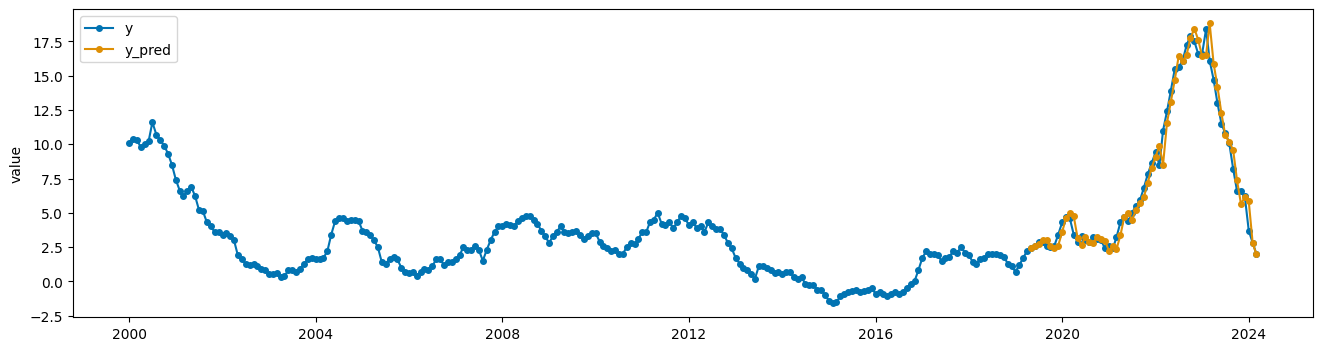

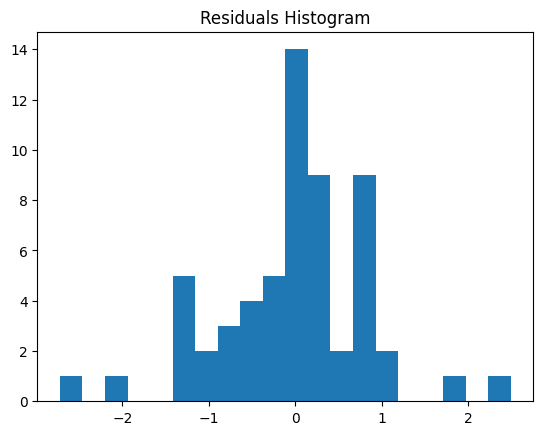

Anderson-Darling test statistic: 1.03, critical values: [0.543 0.619 0.742 0.866 1.03 ]
Residuals are not normally distributed
Ljung-Box test p-value: 0.39479572030868754
No autocorrelation in residuals
AutoARIMA:
MAE: 0.62, SMAPE: 0.10, MASE: 1.84


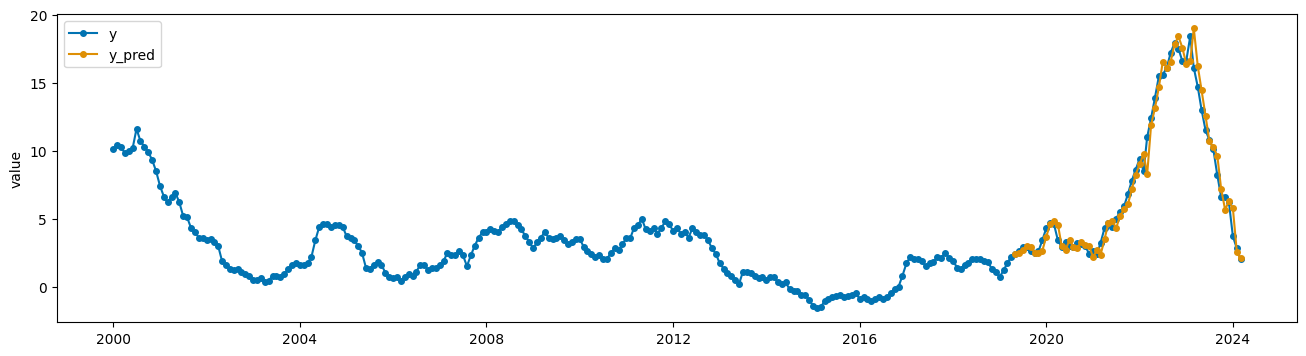

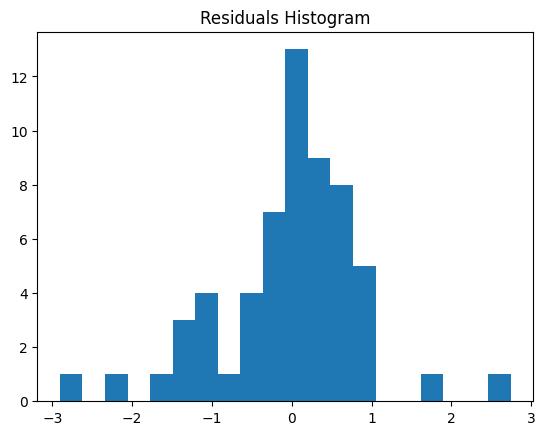

Anderson-Darling test statistic: 1.23, critical values: [0.543 0.619 0.742 0.866 1.03 ]
Residuals are not normally distributed
Ljung-Box test p-value: 0.39065026245565965
No autocorrelation in residuals
AutoSARIMA:
MAE: 0.62, SMAPE: 0.10, MASE: 1.84


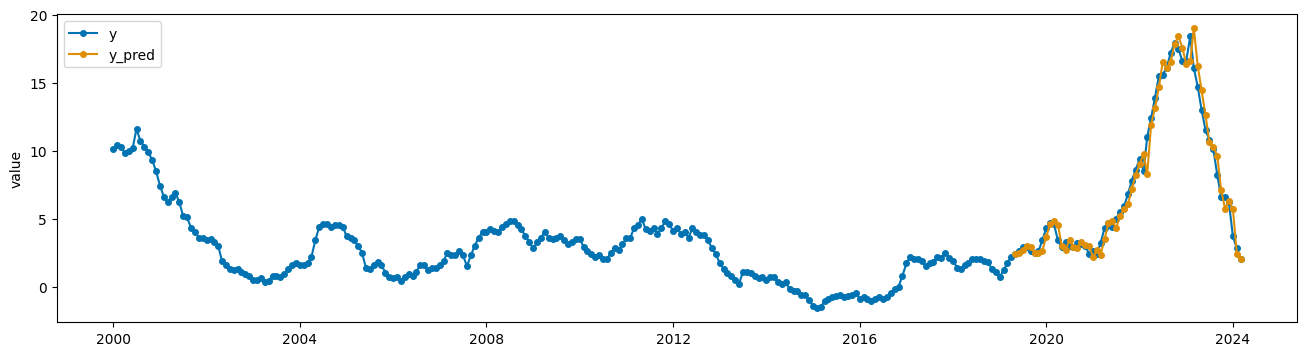

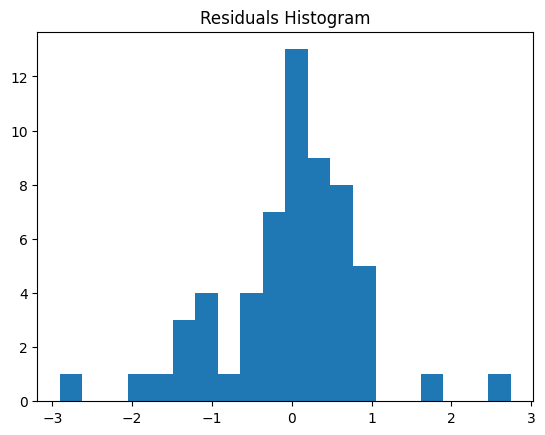

Anderson-Darling test statistic: 1.25, critical values: [0.543 0.619 0.742 0.866 1.03 ]
Residuals are not normally distributed
Ljung-Box test p-value: 0.43612801604183127
No autocorrelation in residuals


In [24]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA


naive_mean = NaiveForecaster(strategy="mean", window_length=30)
naive_last = NaiveForecaster(strategy="last", window_length=30)

auto_ets = AutoETS(auto=True, damped_trend=True, sp=7)

auto_arima = AutoARIMA(suppress_warnings=True, stepwise=True, seasonal=False)

auto_sarima = AutoARIMA(suppress_warnings=True, stepwise=True, seasonal=True, sp=30)

horizon = 1

print("Naive (mean):")
evaluate_model(naive_mean, df, horizon=horizon, plot_forecasts=True, analyze_residuals=True)

print("Naive (last):")
evaluate_model(naive_last, df, horizon=horizon, plot_forecasts=True, analyze_residuals=True)

print("AutoETS:")
evaluate_model(auto_ets, df, horizon=horizon, plot_forecasts=True, analyze_residuals=True)

print("AutoARIMA:")
evaluate_model(auto_arima, df, horizon=horizon, plot_forecasts=True, analyze_residuals=True)

print("AutoSARIMA:")
evaluate_model(auto_sarima, df, horizon=horizon, plot_forecasts=True, analyze_residuals=True)

Może jednak da się lepiej? Nasze dane mają bardzo dużą zmienność, a więc wariancję, a modele ARIMA tego nie lubią. Zastosujmy więc transformacje stabilizujące wariancję. Mamy tu same dodatnie wartości, więc nie będzie tu problemów numerycznych i można używać dowolnych operacji.

Trzeba tutaj wykorzystać `Pipeline` z sktime, bo automatycznie odwróci on wszystkie operacje podczas predykcji. Czasem dokonuje się ewaluacji danych po transformacji, ale typowo interesuje nas jakość na pierwotnych danych. Przekształcenia służą tylko do poprawienia treningu.

**Zadanie 7 (0.5 punktu)**

Stwórz pipeline, składający się z transformacji oraz modelu AutoARIMA (bez sezonowości). Wypróbuj transformacje:
- log
- sqrt
- Box-Cox

Przedstaw na wykresie oraz pierwotny szereg czasowy szereg po transformacji dającej najlepszy wynik.

Funkcję `make_pipeline` oraz klasy implementujące transformacje znajdziesz w sktime.

Skomentuj:
- czy udało się poprawić wynik transformacją?
- oceniając wizualnie, czy udało się ustabilizować wariancję?

In [40]:
from sktime.pipeline import Pipeline, make_pipeline
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.exponent import SqrtTransformer
from sktime.transformations.series.boxcox import LogTransformer

auto_arima = AutoARIMA(suppress_warnings=True, stepwise=True, seasonal=False)

transformations = [LogTransformer(), SqrtTransformer(), BoxCoxTransformer()]

for transform in transformations:
    pipeline = make_pipeline(transform, auto_arima)
    evaluate_model(pipeline, df, horizon=horizon, plot_forecasts=True, analyze_residuals=True)

df_sqrt = transformations[1].fit_transform(df)
plot_series(df_sqrt, title="Sqrt")

# Ciągle mi błędy wyrzucało jak na różne sposoby próbowałem i nie udało mi się ich naprawić

c:\Users\Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\transformations\series\boxcox.py:417: RuntimeWarning: divide by zero encountered in log
  Xt = np.log(scale * (X + offset))
c:\Users\Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\transformations\series\boxcox.py:417: RuntimeWarning: invalid value encountered in log
  Xt = np.log(scale * (X + offset))
c:\Users\Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\utils\parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster TransformedTargetForecaster failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff NaT, and len(y_train)=232.
                The score will be set to nan.
                Failed forecaster with parameters: TransformedTargetForecaster(steps=[LogTransformer(

MAE: nan, SMAPE: nan, MASE: nan


c:\Users\Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\utils\parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster TransformedTargetForecaster failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 26-th data split, on training data y_train with
                cutoff NaT, and len(y_train)=258.
                The score will be set to nan.
                Failed forecaster with parameters: TransformedTargetForecaster(steps=[LogTransformer(),
                                   AutoARIMA(seasonal=False,
                                             suppress_warnings=True)]).
                
  ret = [fun(x, meta=meta) for x in iter]
c:\Users\Paweł\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\transformations\series\boxcox.py:417: RuntimeWarning: divide by zero encountered in log
  Xt = np.log(scale * (X + offset))
c:\User

TypeError: cannot concatenate object of type '<class 'pandas._libs.missing.NAType'>'; only Series and DataFrame objs are valid

## Prognozowanie sprzedaży

Najpowszechniejszym zastosowaniem prognozowania szeregów czasowych jest przewidywanie zapotrzebowania, sprzedaży, popytu, wydatków etc., czyli wszystkich typowych wskaźników dla przedsiębiorstwa. Musi to robić zasadniczo każda firma, dlatego nawet Excel oferuje rozbudowane możliwości prognozowania szeregów czasowych.

Zajmiemy się teraz kluczowym zadaniem dla włoskiej gospodarki, jakim jest prognozowanie sprzedaży makaronu. Zbiór danych został zebrany przez włoskich naukowców na potrzeby [tego artykułu naukowego](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub). Dane pochodzą z lat 2014-2018 (do końca roku), z 4 firm, i dotyczą wielu wyrobów z makaronu. Zawierają też dane o promocjach na poszczególne produkty. Niektórych danych brakuje, i wartości te trzeba imputować.

Dane tego typu mają typowo następujące cechy:
- często trend rosnący, mniejszy lub większy
- mocną sezonowość, często więcej niż jedną
- dużą czułość na powtarzalne okazje, np. weekendy czy święta
- duże i powtarzalne outliery
- dość duży szum i zmienność
- relatywnie niską częstotliwość, dzienną lub niższą
- często długie horyzonty dla prognozowania: miesięczne, kwartalne czy roczne
- zmienne egzogeniczne

**Zadanie 8 (1 punkt)**

1. Wczytaj dane z pliku `"italian_pasta.csv"`
2. Wybierz kolumny z firmy B1 (mają `"B1"` w nazwie) oraz kolumnę `"DATE"`
3. Stwórz kolumnę `"value"`:
   - sumaryczna sprzedaż makaronu
   - suma kolumn z `"QTY"` w nazwie
4. Stwórz kolumnę `"num_promos"`:
   - sumaryczna liczba aktualnych promocji
   - suma kolumn z `"PROMO"` w nazwie
5. Pozostaw tylko kolumny `"DATE"`, `"value"` oraz `"num_promos"`
6. Stwórz indeks typu datetime:
   - zmień typ kolumny `"DATE"` na datetime
   - ustaw tę kolumnę jako indeks
   - ustaw jej częstotliwość (frequency) jako dzienną, `"d"`
7. Podziel dane na:
   - zmienną `y`, `pd.Series` z kolumny `"value"`, główny szereg czasowy
   - zmienną `X`, `pd.Series` z kolumny `"num_promos"`, zmienne egzogeniczne
8. Uzupełnij wartości brakujące w zmiennych egzogenicznych zerami - możemy założyć, że domyślnie nie ma promocji.
9. Przedstaw na wykresie szereg czasowy `y`. Pamiętaj o podaniu tytułu wykresu.

C:\Users\Paweł\AppData\Local\Temp\ipykernel_22036\1120937697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b1["value"] = df_b1.filter(regex="QTY").sum(axis=1)
C:\Users\Paweł\AppData\Local\Temp\ipykernel_22036\1120937697.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b1["num_promos"] = df_b1.filter(regex="PROMO").sum(axis=1)


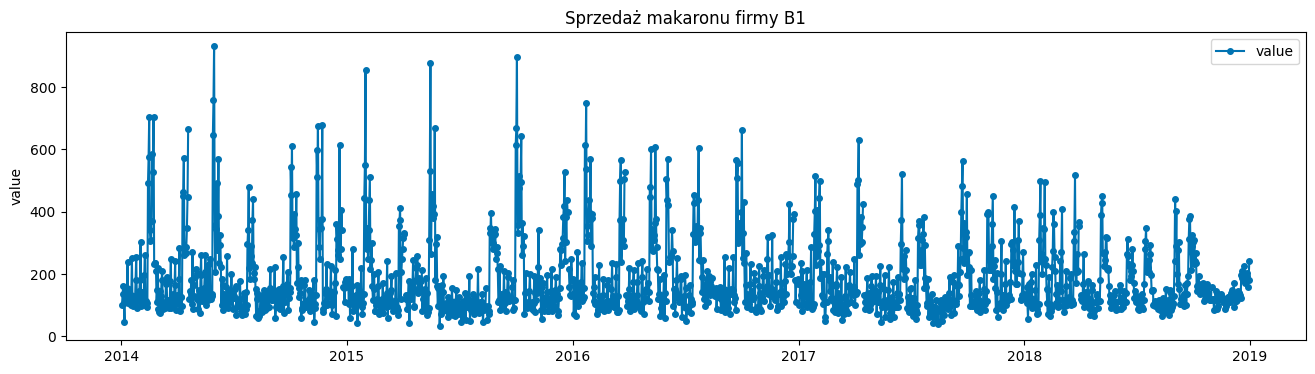

In [41]:
df = pd.read_csv("italian_pasta.csv")

df_b1 = df.filter(regex="B1|DATE")

df_b1["value"] = df_b1.filter(regex="QTY").sum(axis=1)

df_b1["num_promos"] = df_b1.filter(regex="PROMO").sum(axis=1)

df_b1 = df_b1[["DATE", "value", "num_promos"]]

df_b1["DATE"] = pd.to_datetime(df_b1["DATE"])
df_b1.set_index("DATE", inplace=True)
df_b1 = df_b1.asfreq("D")

y = df_b1["value"]
X = df_b1["num_promos"]

X.fillna(0, inplace=True)

plot_series(y, labels=["value"])
plt.title("Sprzedaż makaronu firmy B1")
plt.show()

Tym razem będzie nas interesowało prognozowanie w długim horyzoncie czasowym. Zakładamy, że nasz klient, włoski producent makaronu, ma dane z lat 2014-2017, i chce prognozować swoją sprzedaż w roku 2018. Takie prognozy są potrzebne np. do zakontraktowania długoterminowych dostaw i produkcji na kolejny rok. Z naszej perspektywy jest to trudne, ale przynajmniej szybkie, bo mamy tylko jeden zbiór treningowy i testowy, a nie serię, jak w expanding window.

Do ewaluacji posłuży nam teraz funkcja `evaluate_pasta_sales_model`.

**Zadanie 9 (1 punkt)**

Uzupełnij kod funkcji do ewaluacji:
- podziel `y` na zbiór treningowy i testowy według daty, wszystko od `2018-01-01` włącznie to zbiór testowy
- jeżeli przekazano `X`, to je tak samo podziel
- dokonaj imputacji wartości brakujących w `y`:
  - klasa `Imputer` z sktime
  - zastosuj strategię `ffill` (uzupełnienie ostatnią znaną wartością)
- wytrenuj model (pamiętaj o przekazaniu `X`), dokonaj predykcji
- dokonaj ewaluacji predykcji za pomocą MAE, SMAPE oraz MASE (znajdź odpowiednie funkcje w sktime)
- wypisz wyniki do 2 miejsca po przecinku
- skopiuj kod dla `plot_forecasts` i `analyze_residuals` z zadania 3

In [42]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_scaled_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.base import ForecastingHorizon
from typing import Optional

import numpy as np
from sktime.transformations.series.impute import Imputer


def evaluate_pasta_sales_model(
    model,
    df: pd.Series,
    X: Optional[np.ndarray] = None,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    date = "2018-01-01"

    y_train = df[df.index < date]
    y_test = df[df.index >= date]
    
    X_train, X_test = None, None
    
    if X is not None:
        X_train = X[X.index < date]
        X_test = X[X.index >= date]

    imputer = Imputer(method="ffill", random_state=0)
    y_train = imputer.fit_transform(y_train)
    y_test = imputer.transform(y_test)
    
    model.fit(y_train, X=X_train)
    
    y_pred = model.predict(X=X_test, fh = ForecastingHorizon(y_test.index, is_relative=False))
    y_true = y_test
    
    mae = mean_absolute_error(y_true, y_pred)
    smape = mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred, y_train=y_train)
    
    print(f"MAE: {mae:.2f}")
    print(f"SMAPE: {smape:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        plot_series(y_true, y_pred, labels=["y", "y_pred"])
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        residuals = y_true - y_pred
        plt.hist(residuals, bins=10)
        plt.show()
        
        anderson_result = anderson(residuals)
        print(f"Anderson-Darling test: {anderson_result.fit_result.success}")

        ljungbox_result = acorr_ljungbox(residuals, lags=[10])
        print(f"Ljung-Box test: {ljungbox_result}")

Teraz nie pozostaje nam nic, tylko prognozować.

**Zadanie 10 (1.5 punktu)**

Dokonaj predykcji modelami:
- 2 baseline'ami
- ETS (z damped trend)
- ARIMA
- SARIMA z sezonowością 30 dni
- ARIMAX
- SARIMAX z sezonowością 30 dni

Dla najlepszego modelu wypróbuj transformacje log, sqrt oraz Box-Cox.

Na koniec narysuj predykcje oraz dokonaj analizy błędów dla finalnego modelu.

Skomentuj:
- czy udało się przebić baseline?
- czy finalny model uwzględnia sezonowość i/lub zmienne egzogeniczne (dane o promocjach)?
- czy warto było stosować transformacje danych?
- skomentuj ogólne zachowanie modelu na zbiorze testowym, na podstawie wykresu predykcji
- czy model jest nieobciążony (rozkład normalny błędów o średniej 0), bez autokorelacji, czy jest tutaj miejsce na poprawę?

In [43]:
naive_mean = NaiveForecaster(strategy="mean", window_length=365)
naive_last = NaiveForecaster(strategy="last", window_length=365)

auto_ets = AutoETS(auto=True, sp=30, damped_trend=True)
auto_arima = AutoARIMA(suppress_warnings=True, stepwise=True)
auto_sarima = AutoARIMA(suppress_warnings=True, stepwise=True, sp=30)
auto_arimax = AutoARIMA(suppress_warnings=True, stepwise=True)
auto_sarimax = AutoARIMA(suppress_warnings=True, stepwise=True, seasonal=True, sp=30)


evaluate_pasta_sales_model(model=naive_mean, df = y)

evaluate_pasta_sales_model(model=naive_last, df = y)

evaluate_pasta_sales_model(model=auto_ets, df = y)

evaluate_pasta_sales_model(model=auto_arima, df = y)

evaluate_pasta_sales_model(model=auto_sarima, df = y)

evaluate_pasta_sales_model(model=auto_arimax, df = y, X = X)

evaluate_pasta_sales_model(model=auto_sarimax, df = y, X = X)


MAE: 65.35
SMAPE: 0.45
MASE: 0.99
MAE: 57.60
SMAPE: 0.31
MASE: 0.87
MAE: 1919.85
SMAPE: 14.31
MASE: 29.08
MAE: 70.78
SMAPE: 0.51
MASE: 1.07
MAE: 71.11
SMAPE: 0.52
MASE: 1.08
MAE: 55.75
SMAPE: 0.42
MASE: 0.84
MAE: 43.67
SMAPE: 0.28
MASE: 0.66


In [44]:
print("SARIMAX log")
sarimax_log = make_pipeline(LogTransformer(), AutoARIMA(suppress_warnings=True, stepwise=True, seasonal=True, sp=30))
evaluate_pasta_sales_model(model=sarimax_log, df=y, X=X)


print("SARIMAX sqrt")
sarimax_sqrt = make_pipeline(SqrtTransformer(), AutoARIMA(suppress_warnings=True, stepwise=True, seasonal=True, sp=30))
evaluate_pasta_sales_model(model=sarimax_sqrt, df=y, X=X)

print("SARIMAX Box-Cox")
sarimax_boxcox = make_pipeline(BoxCoxTransformer(), AutoARIMA(suppress_warnings=True, stepwise=True, seasonal=True, sp=30))
evaluate_pasta_sales_model(model=sarimax_boxcox, df=y, X=X)

SARIMAX log
MAE: 42.00
SMAPE: 0.27
MASE: 0.64
SARIMAX sqrt
MAE: 45.78
SMAPE: 0.31
MASE: 0.69
SARIMAX Box-Cox
MAE: 40.82
SMAPE: 0.25
MASE: 0.62


Zmienne egzogeniczne można jeszcze rozbudować - przykładowo, zachowanie kupujących w weekendy i święta jest inne. Typowo sprzedaż mocno rośnie przed i po okresach, kiedy sklepy są zamknięte, no i naturalnie spada do zera, kiedy sklep jest nieczynny.

**Zadanie 11 (0.75 punktu)**

1. Stwórz listę zmiennych reprezentujących święta z pomocą klasy `HolidayFeatures`:
   - przyda się funkcja `country_holidays` z biblioteki `holidays`
   - pamiętaj o tym, że operujemy we Włoszech, skrót kraju `"IT"`
   - uwzględnij weekendy
   - stwórz po prostu jedną zmienną "czy jest święto" (opcje `return_dummies` i `return_indicator`)
2. Dodaj te zmienne do naszych danych o promocjach `X`. Przyda się `pd.merge` oraz opcje `left_index` i `right_index`.
3. Wytrenuj model ARIMAX (lub SARIMAX, jeżeli wcześniej wykryto sezonowość). Wykorzystaj najlepszą transformację z poprzedniego zadania.
4. Skomentuj, jak mają się jego wyniki do wcześniejszych.

MAE: 40.49
SMAPE: 0.25
MASE: 0.61


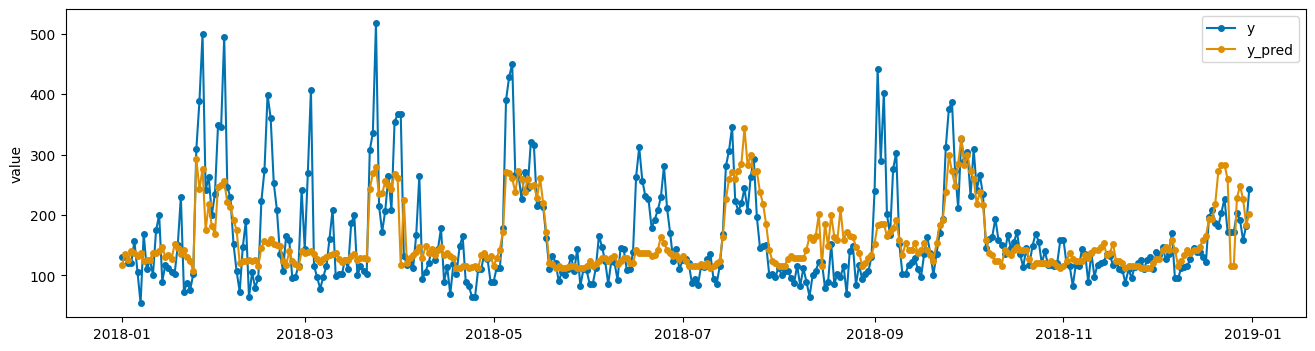

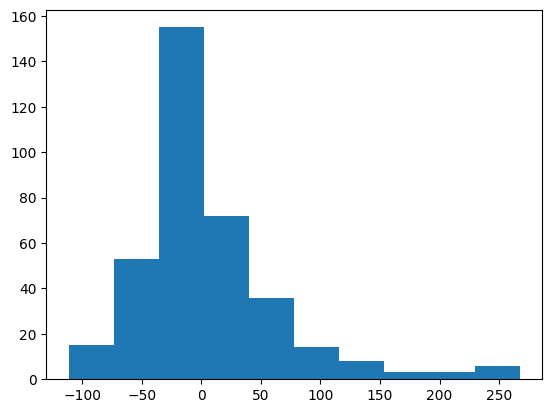

Anderson-Darling test: True
Ljung-Box test:        lb_stat     lb_pvalue
10  189.083975  3.032436e-35


In [45]:
from sktime.transformations.series.holiday import HolidayFeatures
from holidays import country_holidays

holiday_transformer = HolidayFeatures(
    calendar=country_holidays(country="IT"),
    include_weekend=True,
    return_dummies=False,
    return_indicator=True
)

holiday_features = holiday_transformer.fit_transform(X)
X_completed = X.to_frame().merge(holiday_features, left_index=True, right_index=True)

evaluate_pasta_sales_model(model=sarimax_boxcox, df=y, X=X_completed, plot_forecasts=True, analyze_residuals=True)

## Zadanie dodatkowe (3 punkty)

Klasyfikacja szeregów czasowych często wykorzystuje dane z akcelerometrów, smartfonów, smartwatchy i innych tego typu urządzeń. Praktycznie każdy wyżej klasy smartwatch ma wbudowane proste klasyfikatory analizujące aktywność, tętno, ruch itp. Ciekawym zastosowaniem miary takiej aktywności dobowej jest diagnostyka medyczna, bo niektóre choroby powodują nieoczywiste na pierwszy rzut oka zmniejszenie motoryki człowieka.

[Zbiór danych Depresjon](https://datasets.simula.no/depresjon/) dotyczy diagnozy depresji na podstawie aktywności dobowej mierzonej smartwatchem ActiGraph. Zbiór ze względu na wrażliwą naturę problemu jest bardzo mały, 55 pacjentów, ale trzeba sobie z tym radzić, bo w medycynie jest to dość normalne. Pomiary per pacjent są dość długie, około 2 tygodni.

1. Wczytaj dane, upewnij się że mają prawidłowe typy
2. Uzupełnij wartości brakujące per pacjent za pomocą interpolacji liniowej (klasa `Imputer`)
3. Do ewaluacji wykorzystaj podejście z [tego artykułu](https://www.cai.sk/ojs/index.php/cai/article/view/2021_4_850), tzw. nested cross-validation:
   - 5-fold CV (stratified) do testowania (outer)
   - LOOCV do wyboru hiperparametrów (inner)
4. Dokonaj ekstrakcji cech algorytmami:
   - [MiniROCKET](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.rocket.MiniRocket.html)
   - [Shapelet transform](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.shapelet_transform.ShapeletTransform.html)
   - [TSFRESH](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.tsfresh.TSFreshRelevantFeatureExtractor.html) (w wariancie "efficient")
   - [Catch22](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.catch22.Catch22.html)
5. Wykorzystaj regresję logistyczną (`LogisticRegressionCV`) jako klasyfikator
6. Dokonaj ewaluacji za pomocą metryk:
   - balanced accuracy
   - F1
   - precision
   - recall
   - specificity
   - AUROC
   - MCC (Matthews Correlation Coefficient)
7. Porównaj wyniki z [artykułem](https://www.cai.sk/ojs/index.php/cai/article/view/2021_4_850) (tabela 4). Skomentuj, czy udało się przebić te wyniki.